# Negative and nonlinear coabundances through Pearson correlation

In [1]:
net_folder = '/root/host_home/luca/outputARACNE/'
meta_folder = '/root/host_home/luca/metadata/'
nb_dir = '/root/host_home/luca/nb_graphAnalysis/'
cell_type_key = 'cell_type_adjusted'
sample_key = 'sample'

In [ ]:
import os
os.chdir(nb_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import networkx as nx

In [ ]:
# Draw G
def draw_graph(G, ax, title):
    pos = nx.spring_layout(G, seed=0)  # Set the position of the nodes
    nx.draw(G, pos, with_labels=True, node_size=170, font_size=8, font_family="sans-serif", edge_color='black', ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=5, ax=ax)
    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    

def plot_corr_networks(time, corr_threshold=0.3, p_threshold=0.05):
    time_solo = time.split('_')[0]
    # Unstack the group counts
    groups = pd.read_csv(f'{meta_folder}/groups_{time_solo}_zuani.csv', index_col=0)
    groups.sort_values([cell_type_key, sample_key])
    groups.set_index([cell_type_key,sample_key], inplace=True)
    cutoff = groups
    samp_type = cutoff.unstack().transpose()

    # Export a fig of missing samples
    plt.figure(figsize=(14, 9))  # Increase figure size
    plt.bar(samp_type.columns, samp_type.isna().sum())
    plt.ylabel('# missing samples')
    plt.title('# Samples with no Cell Type')
    plt.xticks(rotation=90)
    plt.savefig(f'{nb_dir}/output/missing_samples_{time}.png')
    plt.close()

    # Normalize the counts
    samp_type = samp_type.fillna(0)
    corr_types = (samp_type.T / samp_type.T.sum()).T
    corr_types.reset_index(inplace=True)
    corr_types.index = corr_types[sample_key]
    del corr_types[sample_key]
    del corr_types['level_0']

    # Compute pairwise correlations and p-values
    data = corr_types.to_numpy().T
    # Initialize matrices for correlation coefficients and p-values
    n_variables = data.shape[0]  # Number of variables, eg. cell types``
    pearson_matrix = np.zeros((n_variables, n_variables))
    pearson_p_values = np.zeros((n_variables, n_variables))

    for i in range(n_variables):
        for j in range(n_variables):
            if i == j:
                # The correlation of a variable with itself is always 1, and the p-value is 0
                pearson_matrix[i, j] = 1
                pearson_p_values[i, j] = 0
            elif i < j:
                # Compute correlation and p-value for unique pairs only
                correlation, p_value = pearsonr(data[i], data[j])
                if np.isnan(correlation):
                    print(f'Correlation between {corr_types.columns[i]} and {corr_types.columns[j]} is NaN')
                    correlation = 0
                    p_value = 1
                pearson_matrix[i, j] = pearson_matrix[j, i] = correlation
                pearson_p_values[i, j] = pearson_p_values[j, i] = p_value
                
    pearson_df = pd.DataFrame(pearson_matrix, columns=samp_type.columns, index=samp_type.columns)
    pearson_p_values_df = pd.DataFrame(pearson_p_values, columns=samp_type.columns, index=samp_type.columns)

    # Export the correlation matrix
    pearson_df.to_csv(f'{nb_dir}/output/pearson_{time_solo}.csv')
    pearson_p_values_df.to_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv')

    G = nx.Graph()

    # Add edges between all nodes with correlation as edge attribute
    for col1 in pearson_df.columns:
        for col2 in pearson_df.index:
            if col1 != col2:
                # Add an edge between col1 and col2 with the correlation as an attribute
                G.add_edge(col1, col2, weight=(round(pearson_df.loc[col1, col2],2)))

    # Remove edges with very low correlation and high p-value
    threshold = corr_threshold
    threshold_p = p_threshold
    for (u, v, d) in list(G.edges(data=True)):
        
        if abs(d['weight']) < threshold or abs(pearson_p_values_df.loc[u, v]) > threshold_p:
            G.remove_edge(u, v)
            if any('Fibroblast' in node for node in (u, v)):
                print(u,v)
                print('was removed')
        else:
            if any('Fibroblast' in node for node in (u, v)):
                print(u,v)
                print('was not removed')

    # Remove all nodes with no edges
    nodes_with_no_edges = [node for node, degree in G.degree() if degree == 0]
    G.remove_nodes_from(nodes_with_no_edges)

    # Save the corr_threshold as an attribute of the graph G
    G.graph['corr_threshold'] = corr_threshold

    # Subset to only edges with negative weight
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < 0]
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]
    G_negative = G.edge_subgraph(negative_edges).copy()
    G_positive = G.edge_subgraph(positive_edges).copy()

    _, axes = plt.subplots(1, 3, figsize=(22, 9))  # Create a figure with 2 subplots

    draw_graph(G, axes[0], f'Pearson Corr {time}')

    draw_graph(G_negative, axes[1], f'Negative Corr {time}')

    draw_graph(G_positive, axes[2], f'Positive Corr {time}')

    plt.show()

    return G, G_negative, G_positive, corr_types


def get_nonlinear_edges(time, G_pear):

    G_MI = nx.read_edgelist(f"{net_folder}/net{time}.txt", data=(("MI", float),('p', float)), delimiter='\t')

    # Ensure edges are ordered lexicographically and keep edge attributes
    edges_MI = [(min(u, v), max(u, v)) for u, v in G_MI.edges()]
    edges_pear = [(min(u, v), max(u, v)) for u, v in G_pear.edges()]

    non_linear_edges = set(edges_MI) - set(edges_pear)
    non_signif_edges = set(edges_pear) - set(edges_MI)
    thres = G_pear.graph['corr_threshold']
    print(f'Total MI edges: {len(edges_MI)}')
    print(f'Non linear edges # for {time} with thres={thres}:', len(non_linear_edges))
    return non_linear_edges, non_signif_edges, G_MI

In [197]:
thres = 0.2

## I-II

In [198]:
time = 'I-II_leiden'

was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
Alveolar cell type 1 Fibroblast adventitial
was not removed
Alveolar cell type 1 Fibroblast alveolar
was not removed
Alveolar cell type 1 Fibroblast peribronchial
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was not removed
was n

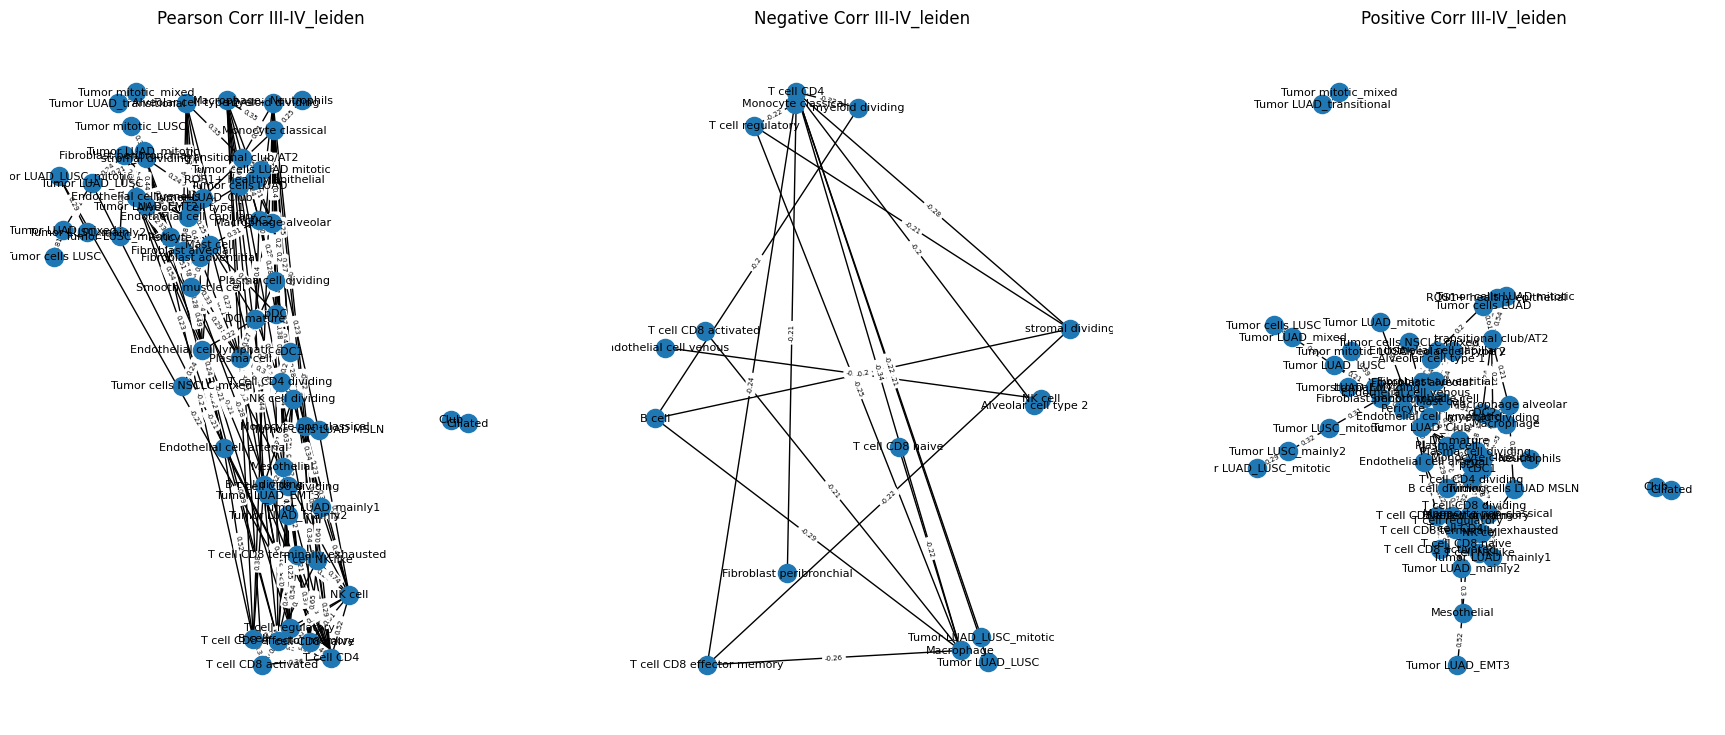

In [225]:
G_I, G_I_neg, G_I_pos, corr_types_I = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [200]:
non_linear_I, non_signif_I, G_MI_I =  get_nonlinear_edges(time, G_I)

Total MI edges: 193
Non linear edges # for I-II_leiden with thres=0.2: 128


## III-IV

In [201]:
time = 'III-IV_leiden'

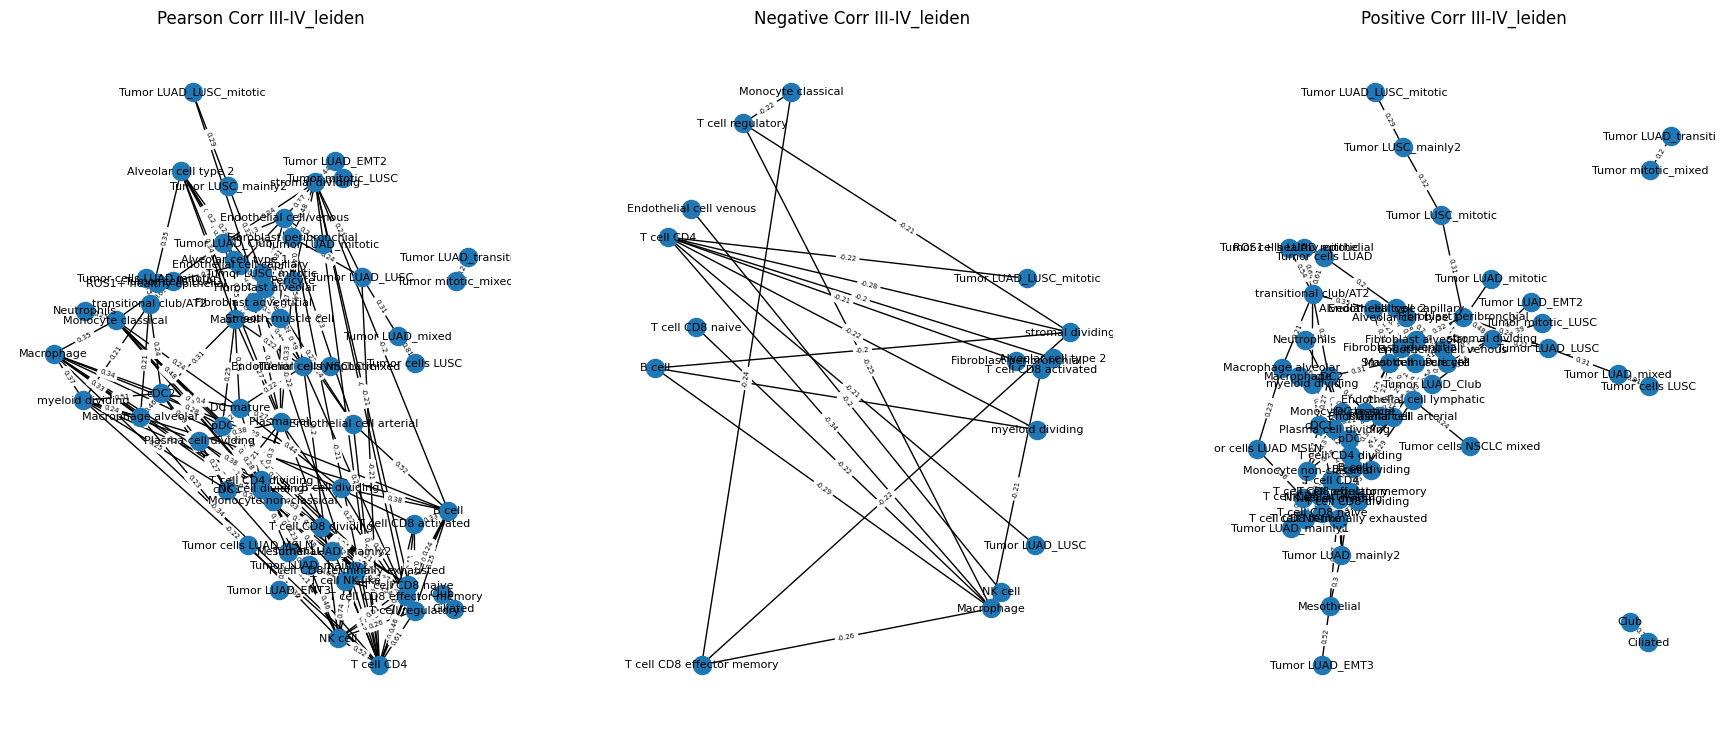

In [202]:
G_III, G_III_neg, G_III_pos, corr_types_III = plot_corr_networks(time, corr_threshold=thres, p_threshold=0.05,)

In [203]:
non_linear_III, non_signif_III, G_MI_III =  get_nonlinear_edges(time, G_III)

Total MI edges: 162
Non linear edges # for III-IV_leiden with thres=0.2: 75


In [204]:
def sample_scatter(time, edge_diff, corr_types, G_MI, n=6, indices=[], log=False):
    
    if len(indices)>0:
        n = len(indices)
        sample_edges = [list(edge_diff)[i] for i in indices]
    else:
        inds = np.random.choice(len(edge_diff), n, replace=False)
        sample_edges = [list(edge_diff)[i] for i in inds]

    time_solo = time.split('_')[0]
    pearson_df = pd.read_csv(f'{nb_dir}/output/pearson_{time_solo}.csv', index_col=0)
    pearson_p_values_df = pd.read_csv(f'{nb_dir}/output/pearson_p_values_{time_solo}.csv', index_col=0)

    # Create scatterplots for each pair
    fig, axes = plt.subplots((n-1)//4 + 1, 4, figsize=(12, 3*((n-1)//4) ) )  # Create a figure with n subplots

    for ax, (var1, var2) in zip(axes.flatten(), sample_edges):
        ax.scatter(corr_types[var1], corr_types[var2], s=2)
        if log:
            ax.set_xscale('log')
            ax.set_yscale('log')
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        corr = round(pearson_df.loc[var1, var2], 2)
        pval = round(pearson_p_values_df.loc[var1, var2], 4)
        try:
            mi = round(G_MI[var1][var2]["MI"], 2)
        except:
            mi = '<0.22'
        ax.set_title(f'P corr: {corr}, pval: {pval} MI: {mi}', size=9)

    plt.tight_layout()
    plt.show()

In [223]:
for u, v in G_I.edges():
    if any('Fibroblast' in node for node in (u, v)):
        print(u,v)

Mast cell Fibroblast alveolar
Endothelial cell venous Fibroblast alveolar
Macrophage Fibroblast peribronchial
T cell CD8 naive Fibroblast alveolar
Tumor LUSC_mainly Fibroblast peribronchial
Fibroblast alveolar Smooth muscle cell
Pericyte Fibroblast adventitial
Pericyte Fibroblast peribronchial
Fibroblast adventitial Fibroblast peribronchial
Fibroblast adventitial Tumor LUAD_mainly1
Fibroblast peribronchial T cell CD8 effector memory
Fibroblast peribronchial Tumor LUAD_LUSC_mitotic
Fibroblast peribronchial Tumor LUAD_mainly1


In [ ]:
pearson_df

cell_type_adjusted,Alveolar cell type 1,Alveolar cell type 2,B cell,B cell dividing,Ciliated,Club,DC mature,Endothelial cell arterial,Endothelial cell capillary,Endothelial cell lymphatic,...,Tumor cells NSCLC mixed,Tumor mitotic_LUSC,Tumor mitotic_mixed,Tumor mixed_LUAD,cDC1,cDC2,myeloid dividing,pDC,stromal dividing,transitional club/AT2
sample,,,,,,,,,,,,,,,,,,,,,
Chen_Zhang_2020_NSCLC-1,0.000000,0.000000,0.424092,0.000550,0.000000,0.000000,0.000550,0.009351,0.044004,0.000000,...,0.0,0.0,0.000000,0.00000,0.002200,0.003850,0.000000,0.002750,0.000000,0.008251
Chen_Zhang_2020_NSCLC-11,0.000241,0.001844,0.019727,0.000000,0.001844,0.000160,0.000561,0.000000,0.000080,0.000321,...,0.0,0.0,0.000000,0.00016,0.000241,0.003208,0.000561,0.000962,0.000080,0.007057
Chen_Zhang_2020_NSCLC-2,0.000000,0.000515,0.142048,0.000000,0.000000,0.000000,0.001029,0.000257,0.000257,0.001544,...,0.0,0.0,0.000000,0.00000,0.003088,0.011580,0.000772,0.001801,0.000257,0.015955
Chen_Zhang_2020_NSCLC-3,0.000000,0.000139,0.107560,0.000000,0.000695,0.000139,0.000695,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00000,0.002084,0.003474,0.000278,0.004864,0.000000,0.001529
Chen_Zhang_2020_NSCLC-6,0.004242,0.012727,0.011219,0.000000,0.003865,0.001037,0.000848,0.000377,0.005939,0.000660,...,0.0,0.0,0.000094,0.00000,0.002734,0.056189,0.012727,0.000848,0.000000,0.005657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zilionis_Klein_2019_p4t1,0.000000,0.003650,0.039234,0.000000,0.000000,0.000000,0.000912,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00000,0.002737,0.020985,0.002737,0.007299,0.000000,0.022810
Zilionis_Klein_2019_p4t2,0.000987,0.003949,0.028628,0.000000,0.000000,0.000000,0.004936,0.000000,0.000987,0.000000,...,0.0,0.0,0.000000,0.00000,0.000987,0.031589,0.001974,0.013820,0.000000,0.025666
Zilionis_Klein_2019_p4t3,0.000791,0.001582,0.026108,0.000000,0.000000,0.000000,0.001582,0.000000,0.000000,0.000791,...,0.0,0.0,0.000000,0.00000,0.001582,0.030063,0.001582,0.006329,0.000000,0.022152


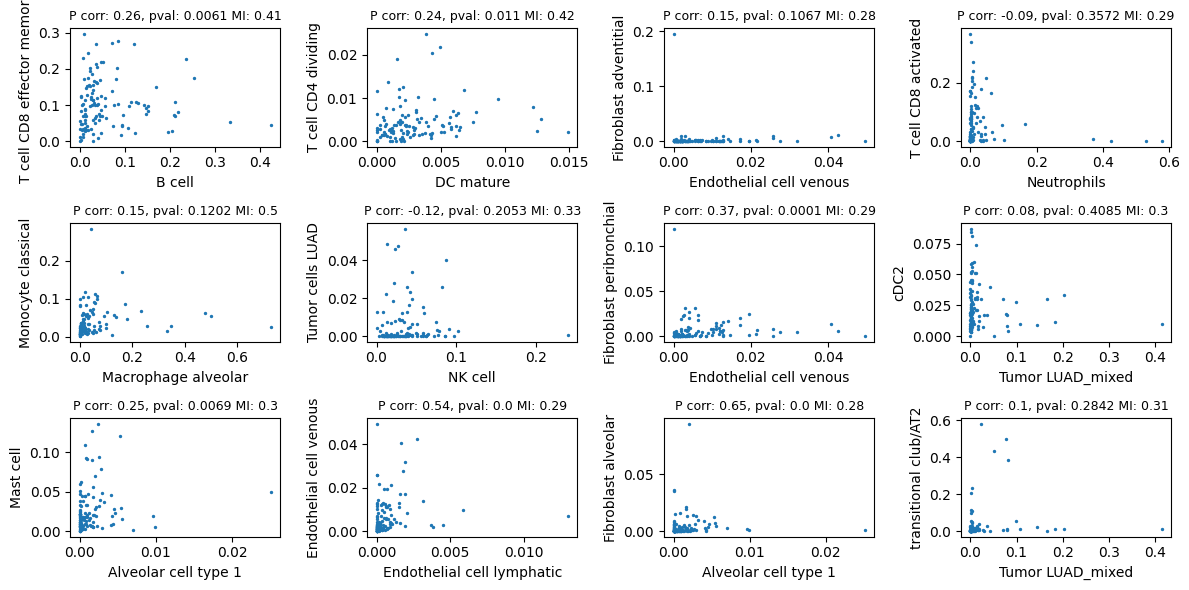

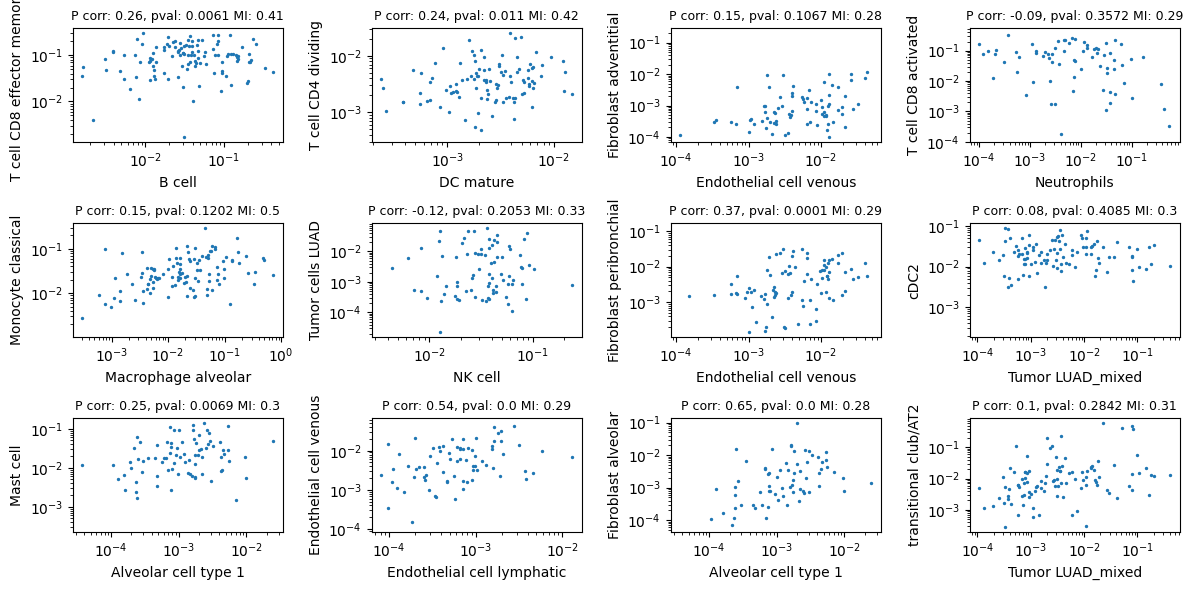

In [207]:
# sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=list(range(0,6)), log=False)
inds = np.random.choice(len(non_linear_I), 12, replace=False)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, log=False)
sample_scatter(time, non_linear_I, corr_types_I, G_MI_I, indices=inds, log=True)

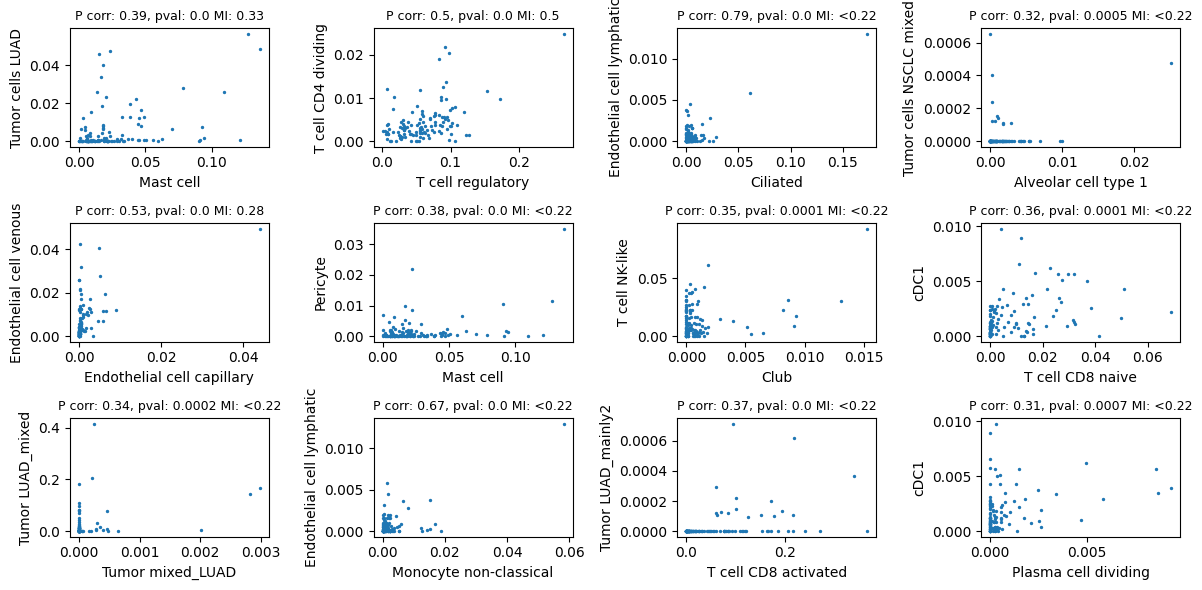

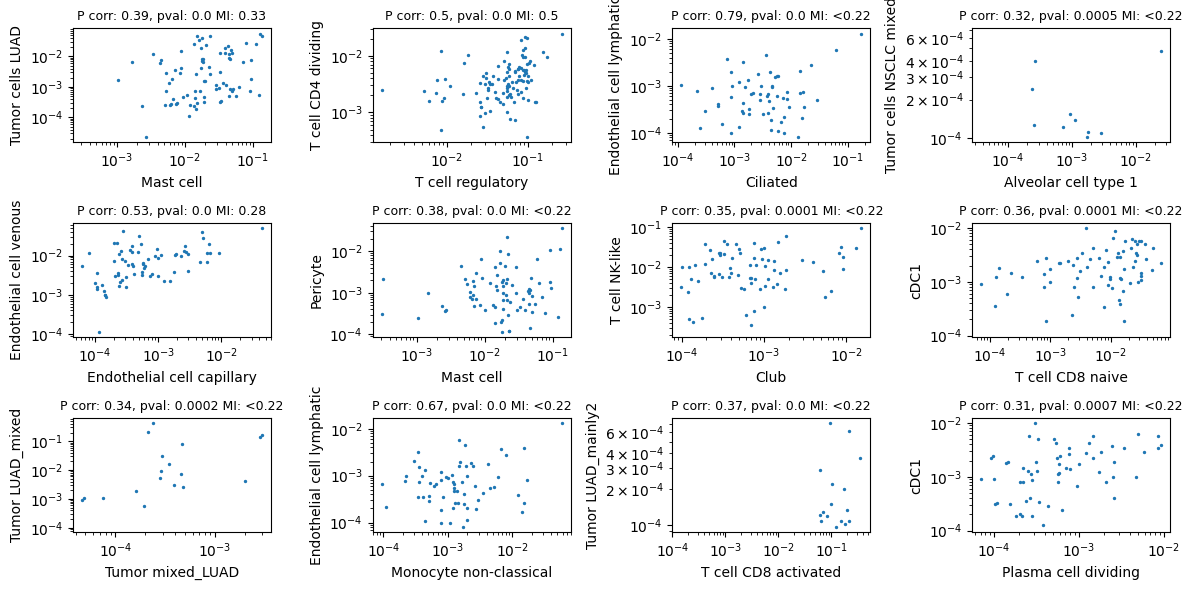

In [134]:
inds = np.random.choice(len(non_signif_I), 12, replace=False)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, log=False)
sample_scatter(time, non_signif_I, corr_types_I, G_MI_I, indices=inds, log=True)